<a href="https://colab.research.google.com/github/cqulihui/two_sentences_classifier/blob/master/R14_leadership_chatdisentangle_disentangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 会话结构的计算

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path="/content/drive/My Drive/Colab Notebooks/R14-leadership-word2vec"
os.chdir(path)
os.listdir(path)

['data',
 'chatdata',
 'model',
 'R14-leadership-chatdisentangle-word2vec.ipynb',
 'R14-leadership-chatdisentangle-disentangle.ipynb']

## 整理数据

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
allcorpus = pd.read_csv(path + "/chatdata/2-two sentences-chatcorpus.txt", sep = '\t')
allcorpus.columns

Index(['msgid1', 'sender1', 'receiver1', 'createdtime1', 'content1',
       'chatsession1', 'cutcontent1', 'before_msg_id1', 'after_msg_id1',
       'msgid2', 'sender2', 'receiver2', 'createdtime2', 'content2',
       'chatsession2', 'cutcontent2', 'before_msg_id2', 'after_msg_id2',
       'timedifference'],
      dtype='object')

In [ ]:
allcorpus.insert(19, 'samesession', 0)
i = 0
while i < allcorpus.shape[0]:
  if allcorpus.iloc[i,5] == allcorpus.iloc[i,14]:
    allcorpus.iloc[i,19] = 1
  i = i + 1
allcorpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession
0,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,0,1
1,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,66,1
2,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,87CD8A9588004872830880F040FC47B1,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:25,我切换账号后什么都没了..,ei01,我 切换 账号 后 什么 都 没 了 ..,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,75,1
3,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:32:12,发几条单聊我,ei01,发 几条 单聊 我,87CD8A9588004872830880F040FC47B1,NaN,422,1
4,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,0,1


In [ ]:
#增加一个字段，即反映两句话是否相邻的指标。1-相邻；0-不相邻
#allcorpus.insert(19, 'isadjacent', 0)
allcorpus = allcorpus.assign(isadjacent = (allcorpus.before_msg_id1==allcorpus.msgid2) | (allcorpus.after_msg_id1==allcorpus.msgid2))

In [ ]:
allcorpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
0,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,0,1,False
1,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,66,1,True
2,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,87CD8A9588004872830880F040FC47B1,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:25,我切换账号后什么都没了..,ei01,我 切换 账号 后 什么 都 没 了 ..,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,75,1,False
3,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:32:12,发几条单聊我,ei01,发 几条 单聊 我,87CD8A9588004872830880F040FC47B1,NaN,422,1,False
4,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,0,1,False


In [ ]:
#去掉msgid1和msgid2相同的记录
allcorpus = allcorpus.assign(samecontent = (allcorpus.msgid1!=allcorpus.msgid2))
allcorpus = allcorpus[allcorpus['samecontent']]
allcorpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent,samecontent
1,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,66,1,True,True
2,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,87CD8A9588004872830880F040FC47B1,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:25,我切换账号后什么都没了..,ei01,我 切换 账号 后 什么 都 没 了 ..,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,75,1,False,True
3,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:32:12,发几条单聊我,ei01,发 几条 单聊 我,87CD8A9588004872830880F040FC47B1,NaN,422,1,False,True
5,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,87CD8A9588004872830880F040FC47B1,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:25,我切换账号后什么都没了..,ei01,我 切换 账号 后 什么 都 没 了 ..,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,9,1,True,True
6,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:32:12,发几条单聊我,ei01,发 几条 单聊 我,87CD8A9588004872830880F040FC47B1,NaN,356,1,False,True


In [ ]:
allcorpus = allcorpus.drop('samecontent', axis = 1)
allcorpus['isadjacent'] = allcorpus['isadjacent'].map({True: 1, False: 0})
allcorpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
1,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,66,1,1
2,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,87CD8A9588004872830880F040FC47B1,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:25,我切换账号后什么都没了..,ei01,我 切换 账号 后 什么 都 没 了 ..,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,75,1,0
3,721998824A234DEDB77FD0D7B870BD5E,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:25:10,没有保存,ei01,没有 保存,NaN,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:32:12,发几条单聊我,ei01,发 几条 单聊 我,87CD8A9588004872830880F040FC47B1,NaN,422,1,0
5,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,87CD8A9588004872830880F040FC47B1,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:25,我切换账号后什么都没了..,ei01,我 切换 账号 后 什么 都 没 了 ..,4CB4BFFA145546B9B32052973D0D3782,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,9,1,1
6,4CB4BFFA145546B9B32052973D0D3782,e008521d2ba29baf8d9e50238142ac5f,i46lzkpoocvxe8gu,2019-04-13 23:26:16,在群里说下,ei01,在 群里 说 下,721998824A234DEDB77FD0D7B870BD5E,87CD8A9588004872830880F040FC47B1,Fu7RyGYOXtB8srVYvgFCx2KfsDy9CyFP,i46lzkpoocvxe8gu,e008521d2ba29baf8d9e50238142ac5f,2019-04-13 23:32:12,发几条单聊我,ei01,发 几条 单聊 我,87CD8A9588004872830880F040FC47B1,NaN,356,1,0


In [ ]:
#corpus1 = allcorpus[allcorpus['samesession']==1].sample(n=10000, random_state=None, axis=0)
corpus1 = allcorpus[allcorpus['samesession']==1].sample(n=7000, random_state=None, axis=0)
corpus1.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
404561,NscUpsJZpkk6F1MZY2CowtiLa6KBk4Ph,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:19:30,直接跑,ad21,直接 跑,3G9g9orQmvDpOSbTEylVzXmT2qJYqCiQ,Wy13f1RCxTnf1LqNOD0Hr1ks3nluEssM,FFcnHBoYBrdajWBx507EpQYjuTRWuNJY,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-28 20:14:25,他们都看不到,ad21,他们 都 看不到,lNtsJfEhH0XzmdG3DfgFD16Wm4i2Gkn3,ad9a3f3366394a5aa2a118ae607c62eb,35695,1,0
756645,DDEB2FC8421646B2A4D4F5093BDA7A8B,32eccf456822cf7fe63cdc119b9e2d99,fea143853b78b670d06ec384c4fb7dd6,2019-05-10 18:33:04,哦 我看到了 没事的,f311,哦 我 看到 了 没事 的,4A85BC9E228A49CFBC8737EEB031E7A8,2A8E304A528E4F42B52C72D212258C05,71787EAD4D524B69BF6FB758F08196AD,fea143853b78b670d06ec384c4fb7dd6,32eccf456822cf7fe63cdc119b9e2d99,2019-05-10 18:40:57,[图片],f311,[ 图片 ],0513C7D8AA5A4568BC04BCB98EBEC0C6,B7EFCA8EBB0D4C33966D5BFE52C807F5,473,1,0
1145352,zFlq9VMK4HIi0kqdtTqxIocOvZYHDTKM,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 14:30:19,替换好了,ad74,替换 好 了,USKCz8GoC3EG3wdO59i92y0bZ1hVVVd3,hdBbibDb0r9DfDOcRjyNu0hzbzhDycB5,hs4NqLQL9nXBz3OLIlEGcUBncTMWoERb,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 15:03:51,阔以了,ad74,阔以 了,7rvBnFH6pBZdQQR924kkr5B9WfxXh5oW,VwdqauSe6GxWYcCoP1miiTzxRfDWTfN2,2012,1,0
368458,MvPaIE1nCJaZdTKPR0VFsHLKooGpX41W,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 09:51:45,汤江涛还在用,ad21,汤江涛 还 在 用,OKDvJXCkQEYXlGBIzm6QTbXDidTjioL9,67flK6MRCuaYJ1vicJFwLrCKj3gkQoNh,NscUpsJZpkk6F1MZY2CowtiLa6KBk4Ph,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:19:30,直接跑,ad21,直接 跑,3G9g9orQmvDpOSbTEylVzXmT2qJYqCiQ,Wy13f1RCxTnf1LqNOD0Hr1ks3nluEssM,1665,1,0
153901,ZeudWF5NBXjP7n7smkYpAmbNzF75xmTe,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 16:43:07,nginx转的地址是,ad01,nginx 转 的 地址 是,EGPEVsJsOESJL2sTAKPNd1d6D7knznKg,aiYUuGZw0CRKxogRavHv4kXZRKUrWoLx,DXCzmOMH4Tx5b8cNlvux8WCFPTb0lAEV,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 19:49:22,峰哥记得下次上线把那个config.ini 备份下,ad01,峰哥 记得 下次 上线 把 那个 config . ini 备份 下,30MrvKJzlD7FSdFDZryu9cAArFPRBuMi,BG4G4EFWlwvtGKI8EsN5HUahcsSZdQPc,11175,1,0


In [ ]:
corpus2 = allcorpus[allcorpus['samesession']==0].sample(n=7000, random_state=None, axis=0)
#corpus2 = allcorpus[allcorpus['samesession']==0].sample(n=10000, random_state=None, axis=0)
corpus2.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
640170,F53GMJ0c99VJaDDnqZ6POvGBZR0AFEkp,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-08 16:41:29,嗯嗯 ，你是直接要看文件还是copy,ad33,嗯 嗯 ， 你 是 直接 要 看 文件 还是 copy,VScDcVtHD05JsQTZsmY5nA1rnM64UP7C,nTIXHmn8ibM4AkHTOh4PpV4kfpcMHKdq,hr8Diu77cOqfugeGpM390AHN5LYUMVSO,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-04-28 19:45:35,远程在250上面‘,ad21,远程 在 250 上面 ‘,VjkHavMLP0TCxulSfOsLdk0I7OmgzRSj,ncGEIKVKJX9uZqGa4WzWjDDvs82V8dRl,11046,0,0
918523,UU8EtD6bRvTqHoAVIVC04wC9vITsyKOk,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-22 15:51:04,加了后前端解析出错。 生产环境和测试环境不一样。,ad60,加 了 后 前端 解析 出错 。 生产 环境 和 测试环境 不 一样 。,WjijcHY63cY1ckRhNB2Cz4ZZKcSdlJZX,Yssn3q2GqZgzDXb5SqejXycAPMCSoLYJ,kIwYI7UrkGRuaRoTYCJ5PcrFkg8qQVyN,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-21 20:50:26,你是在看appsapi 日志吗,ad59,你 是 在 看 appsapi 日志 吗,OBgUkP9I3J0VqZGiXFj12R9qrFs44CGv,4OGSJD8O7nie7cgSRivZvCxXiygAkuej,17962,0,0
747279,ad821fda2a0e47dc97d5c1b9a9082e4c,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-10 16:59:06,改的多吗，我一会是整包替换会覆盖。,ad37,改 的 多 吗 ， 我 一会 是 整包 替换 会 覆盖 。,J06LHI3XDH4rhbJ5ZRTCyiKWB0kmY0qV,uZiCA9Fzh6tTXiTHD5FSNNbOb6oQKJjU,McfBAx1AdRC4KP4AlgeNgN1crTAqkmek,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-10 21:35:27,没有新包是吧,ad42,没有 新包 是 吧,p9FaP1pYGgRhGkCzUlMvxmm9fTa9mu5J,rt0YvijcEMkgx63VHtlxUXLTbv56b2f8,16581,0,0
917848,UU8EtD6bRvTqHoAVIVC04wC9vITsyKOk,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-22 15:51:04,加了后前端解析出错。 生产环境和测试环境不一样。,ad60,加 了 后 前端 解析 出错 。 生产 环境 和 测试环境 不 一样 。,WjijcHY63cY1ckRhNB2Cz4ZZKcSdlJZX,Yssn3q2GqZgzDXb5SqejXycAPMCSoLYJ,2NhzFBbE3CU5TeSbEXp7QaPfQQp356n8,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-04-28 17:07:15,我这边可以登陆啊,ad20,我 这边 可以 登陆 啊,b842OQLFvKZCWrGFviQProvq8Mo3u9CV,GfpBu4hBR7BHsWqH8YNPwUSAhfMRKJIg,4571,0,0
167000,Dok3rO2waBDppqeJILXDo4xIYMQRnUnN,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 17:10:14,249你登录这吗,ad01,249 你 登录 这 吗,dxyoUPaIhNfalangkfmYlK8ZSeor7uXJ,rOX7nguvPRTWAvC8CF24AxErPrx6BCPY,qgpW6S9G5vijU2c8FbaxP0JruotoKoB3,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-04-29 19:46:47,为啥？,ad27,为啥 ？,dK7IcQ8bIaWSa4d3lt5XS4B3rleDpiae,agJMmDFM4xy7PWL11Ly1DePtENxffjRo,9393,0,0


In [ ]:
col_name = allcorpus.columns
corpus = pd.DataFrame(columns = col_name)
corpus = corpus.append(corpus1, ignore_index = True)
corpus = corpus.append(corpus2, ignore_index = True)
corpus.shape[0]

14000

In [ ]:
corpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
0,NscUpsJZpkk6F1MZY2CowtiLa6KBk4Ph,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:19:30,直接跑,ad21,直接 跑,3G9g9orQmvDpOSbTEylVzXmT2qJYqCiQ,Wy13f1RCxTnf1LqNOD0Hr1ks3nluEssM,FFcnHBoYBrdajWBx507EpQYjuTRWuNJY,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-28 20:14:25,他们都看不到,ad21,他们 都 看不到,lNtsJfEhH0XzmdG3DfgFD16Wm4i2Gkn3,ad9a3f3366394a5aa2a118ae607c62eb,35695,1,0
1,DDEB2FC8421646B2A4D4F5093BDA7A8B,32eccf456822cf7fe63cdc119b9e2d99,fea143853b78b670d06ec384c4fb7dd6,2019-05-10 18:33:04,哦 我看到了 没事的,f311,哦 我 看到 了 没事 的,4A85BC9E228A49CFBC8737EEB031E7A8,2A8E304A528E4F42B52C72D212258C05,71787EAD4D524B69BF6FB758F08196AD,fea143853b78b670d06ec384c4fb7dd6,32eccf456822cf7fe63cdc119b9e2d99,2019-05-10 18:40:57,[图片],f311,[ 图片 ],0513C7D8AA5A4568BC04BCB98EBEC0C6,B7EFCA8EBB0D4C33966D5BFE52C807F5,473,1,0
2,zFlq9VMK4HIi0kqdtTqxIocOvZYHDTKM,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 14:30:19,替换好了,ad74,替换 好 了,USKCz8GoC3EG3wdO59i92y0bZ1hVVVd3,hdBbibDb0r9DfDOcRjyNu0hzbzhDycB5,hs4NqLQL9nXBz3OLIlEGcUBncTMWoERb,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 15:03:51,阔以了,ad74,阔以 了,7rvBnFH6pBZdQQR924kkr5B9WfxXh5oW,VwdqauSe6GxWYcCoP1miiTzxRfDWTfN2,2012,1,0
3,MvPaIE1nCJaZdTKPR0VFsHLKooGpX41W,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 09:51:45,汤江涛还在用,ad21,汤江涛 还 在 用,OKDvJXCkQEYXlGBIzm6QTbXDidTjioL9,67flK6MRCuaYJ1vicJFwLrCKj3gkQoNh,NscUpsJZpkk6F1MZY2CowtiLa6KBk4Ph,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:19:30,直接跑,ad21,直接 跑,3G9g9orQmvDpOSbTEylVzXmT2qJYqCiQ,Wy13f1RCxTnf1LqNOD0Hr1ks3nluEssM,1665,1,0
4,ZeudWF5NBXjP7n7smkYpAmbNzF75xmTe,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 16:43:07,nginx转的地址是,ad01,nginx 转 的 地址 是,EGPEVsJsOESJL2sTAKPNd1d6D7knznKg,aiYUuGZw0CRKxogRavHv4kXZRKUrWoLx,DXCzmOMH4Tx5b8cNlvux8WCFPTb0lAEV,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 19:49:22,峰哥记得下次上线把那个config.ini 备份下,ad01,峰哥 记得 下次 上线 把 那个 config . ini 备份 下,30MrvKJzlD7FSdFDZryu9cAArFPRBuMi,BG4G4EFWlwvtGKI8EsN5HUahcsSZdQPc,11175,1,0


In [ ]:
corpus.columns

Index(['msgid1', 'sender1', 'receiver1', 'createdtime1', 'content1',
       'chatsession1', 'cutcontent1', 'before_msg_id1', 'after_msg_id1',
       'msgid2', 'sender2', 'receiver2', 'createdtime2', 'content2',
       'chatsession2', 'cutcontent2', 'before_msg_id2', 'after_msg_id2',
       'timedifference', 'samesession', 'isadjacent'],
      dtype='object')

In [ ]:
!pip install zhon

     |████████████████████████████████| 102kB 6.0MB/s 
  Created wheel for zhon: filename=zhon-1.1.5-cp36-none-any.whl size=84293 sha256=39e03d417a476e0dd6052ce3a594163c9e95f034f112b2346f4aa9074a861949
  Stored in directory: /root/.cache/pip/wheels/0e/93/5a/ad2f403c359ba996e33c21bf18611d921413df9740ede2fcf4
Successfully built zhon


In [ ]:
#去除标点符号 (https://github.com/tsroten/zhon)
import re
import string
import jieba
from zhon.hanzi import punctuation

#去中文标点以及特殊符号
def clean_punctuation(text):
  document = re.sub("[{}]+".format(punctuation), "", text)
  return document
#去除英文标点符号以及特殊符号
def clean_en_punctuation(text):
  trantab = str.maketrans({key: None for key in string.punctuation})
  doc = text.translate(trantab)
  document = re.sub("[!#$%&\'()*+,-./:;<=>?@，。?★？[\\]^_`{|}~\s]+", "", doc)
  return document
#分词得到分词后的list
def cutsentence(text):
  document = jieba.lcut(text)
  return document
#去停用词
def delete_stopwords(text):
  filestopword = path + '/chatdata/hit_stopwords.txt'
  stopwords = [line.strip().decode('utf-8') for line in open(filestopword,'rb').readlines()]

  document = [w for w in text if w not in stopwords and len(w)>=2]

  return document

#先替换词汇，再去掉标点，再分词
corpus['cutcontent1'] = corpus['content1'].apply(lambda x: x.replace('haode','好的'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('hao','好'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('enen','嗯嗯'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Joywok','乐工'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('joywok','乐工'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('dogesoft','道勤',))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('icon','图标'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Detail','细节'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('detail','细节'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('plan','计划'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('CRM','客户关系管理软件'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('profile','简介页面'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('team','团队'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('he','和'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('JMIS','企业应用快速开发框架'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('jmis','企业应用快速开发框架'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('app','手机应用程序'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('APP','手机应用程序'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('App','手机应用程序'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('ok','好'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('staging环境','模拟环境'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Staging环境','模拟环境'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('subfunction','副职能'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('function','职能'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('sbux','星巴克'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Sbux','星巴克'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Starbucks','星巴克'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('starbucks','星巴克'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('starbuck','星巴克'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('JS SDK','开发工具包'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('UDID','唯一设备标识符'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('test环境','测试环境'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('IP','网络地址'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('ip','网络地址'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('H5','超文本标记语言5'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('HTML','超文本标记语言'))
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('ssl','安全套接字协议'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('BPM','业务流程管理应用'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('RabbitMQ','开源消息代理软件'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('rabbitmq','开源消息代理软件'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('devicetoken','设备令牌'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('deviceToken','设备令牌'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('bundle-id','软件标识'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('BUSHI','不是'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('UAT','用户接受测试'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('douwei',' '))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Agenda','agenda'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('concall','conference call'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('saas','SaaS'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Pls','pls'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('IAG','接入网关'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('Issuer',' '))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('SF',' '))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('linemanager','line manager'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('METRO','麦德龙'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('metro','麦德龙'))
corpus['cutcontent1'] = corpus['cutcontent1'].apply(lambda x: x.replace('SC',' '))

corpus['cutcontent1'] = corpus['cutcontent1'].apply(clean_punctuation)
corpus['cutcontent1'] = corpus['cutcontent1'].apply(clean_en_punctuation)
corpus['cutcontent1'] = corpus['cutcontent1'].apply(cutsentence)
#corpus['cutcontent1'] = corpus['cutcontent1'].apply(delete_stopwords)

corpus['cutcontent2'] = corpus['content2'].apply(lambda x: x.replace('haode','好的'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('hao','好'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('enen','嗯嗯'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Joywok','乐工'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('joywok','乐工'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('dogesoft','道勤',))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('icon','图标'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Detail','细节'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('detail','细节'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('plan','计划'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('CRM','客户关系管理软件'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('profile','简介页面'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('team','团队'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('he','和'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('JMIS','企业应用快速开发框架'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('jmis','企业应用快速开发框架'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('app','手机应用程序'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('APP','手机应用程序'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('App','手机应用程序'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('ok','好'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('staging环境','模拟环境'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Staging环境','模拟环境'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('subfunction','副职能'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('function','职能'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('sbux','星巴克'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Sbux','星巴克'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Starbucks','星巴克'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('starbucks','星巴克'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('starbuck','星巴克'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('JS SDK','开发工具包'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('UDID','唯一设备标识符'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('test环境','测试环境'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('IP','网络地址'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('ip','网络地址'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('H5','超文本标记语言5'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('HTML','超文本标记语言'))
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('ssl','安全套接字协议'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('BPM','业务流程管理应用'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('RabbitMQ','开源消息代理软件'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('rabbitmq','开源消息代理软件'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('devicetoken','设备令牌'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('deviceToken','设备令牌'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('bundle-id','软件标识'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('BUSHI','不是'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('UAT','用户接受测试'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('douwei',' '))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Agenda','agenda'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('concall','conference call'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('saas','SaaS'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Pls','pls'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('IAG','接入网关'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('Issuer',' '))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('SF',' '))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('linemanager','line manager'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('METRO','麦德龙'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('metro','麦德龙'))
corpus['cutcontent2'] = corpus['cutcontent2'].apply(lambda x: x.replace('SC',' '))

corpus['cutcontent2'] = corpus['cutcontent2'].apply(clean_punctuation)
corpus['cutcontent2'] = corpus['cutcontent2'].apply(clean_en_punctuation)
corpus['cutcontent2'] = corpus['cutcontent2'].apply(cutsentence)
#corpus['cutcontent2'] = corpus['cutcontent2'].apply(delete_stopwords)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.777 seconds.
Prefix dict has been built successfully.


In [ ]:
#为了不改动后面的程序，这里没有去掉这一列
corpus.insert(7, 'cutlist1', np.nan)
corpus['cutlist1'] = corpus['cutcontent1']

In [ ]:
corpus.insert(17, 'cutlist2', np.nan)
corpus['cutlist2'] = corpus['cutcontent2']

In [ ]:
corpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,cutlist1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,cutlist2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
0,NscUpsJZpkk6F1MZY2CowtiLa6KBk4Ph,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:19:30,直接跑,ad21,"[直接, 跑]","[直接, 跑]",3G9g9orQmvDpOSbTEylVzXmT2qJYqCiQ,Wy13f1RCxTnf1LqNOD0Hr1ks3nluEssM,FFcnHBoYBrdajWBx507EpQYjuTRWuNJY,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-28 20:14:25,他们都看不到,ad21,"[他们, 都, 看不到]","[他们, 都, 看不到]",lNtsJfEhH0XzmdG3DfgFD16Wm4i2Gkn3,ad9a3f3366394a5aa2a118ae607c62eb,35695,1,0
1,DDEB2FC8421646B2A4D4F5093BDA7A8B,32eccf456822cf7fe63cdc119b9e2d99,fea143853b78b670d06ec384c4fb7dd6,2019-05-10 18:33:04,哦 我看到了 没事的,f311,"[哦, 我, 看到, 了, 没事, 的]","[哦, 我, 看到, 了, 没事, 的]",4A85BC9E228A49CFBC8737EEB031E7A8,2A8E304A528E4F42B52C72D212258C05,71787EAD4D524B69BF6FB758F08196AD,fea143853b78b670d06ec384c4fb7dd6,32eccf456822cf7fe63cdc119b9e2d99,2019-05-10 18:40:57,[图片],f311,[图片],[图片],0513C7D8AA5A4568BC04BCB98EBEC0C6,B7EFCA8EBB0D4C33966D5BFE52C807F5,473,1,0
2,zFlq9VMK4HIi0kqdtTqxIocOvZYHDTKM,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 14:30:19,替换好了,ad74,"[替换, 好, 了]","[替换, 好, 了]",USKCz8GoC3EG3wdO59i92y0bZ1hVVVd3,hdBbibDb0r9DfDOcRjyNu0hzbzhDycB5,hs4NqLQL9nXBz3OLIlEGcUBncTMWoERb,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 15:03:51,阔以了,ad74,"[阔以, 了]","[阔以, 了]",7rvBnFH6pBZdQQR924kkr5B9WfxXh5oW,VwdqauSe6GxWYcCoP1miiTzxRfDWTfN2,2012,1,0
3,MvPaIE1nCJaZdTKPR0VFsHLKooGpX41W,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 09:51:45,汤江涛还在用,ad21,"[汤江涛, 还, 在, 用]","[汤江涛, 还, 在, 用]",OKDvJXCkQEYXlGBIzm6QTbXDidTjioL9,67flK6MRCuaYJ1vicJFwLrCKj3gkQoNh,NscUpsJZpkk6F1MZY2CowtiLa6KBk4Ph,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:19:30,直接跑,ad21,"[直接, 跑]","[直接, 跑]",3G9g9orQmvDpOSbTEylVzXmT2qJYqCiQ,Wy13f1RCxTnf1LqNOD0Hr1ks3nluEssM,1665,1,0
4,ZeudWF5NBXjP7n7smkYpAmbNzF75xmTe,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 16:43:07,nginx转的地址是,ad01,"[nginx, 转, 的, 地址, 是]","[nginx, 转, 的, 地址, 是]",EGPEVsJsOESJL2sTAKPNd1d6D7knznKg,aiYUuGZw0CRKxogRavHv4kXZRKUrWoLx,DXCzmOMH4Tx5b8cNlvux8WCFPTb0lAEV,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 19:49:22,峰哥记得下次上线把那个config.ini 备份下,ad01,"[峰哥, 记得, 下次, 上线, 把, 那个, configini, 备份, 下]","[峰哥, 记得, 下次, 上线, 把, 那个, configini, 备份, 下]",30MrvKJzlD7FSdFDZryu9cAArFPRBuMi,BG4G4EFWlwvtGKI8EsN5HUahcsSZdQPc,11175,1,0


In [ ]:
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,cutlist1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,cutlist2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
0,d1UlB7Qf0FRNowRVlsX4aYHzl6LeqwuT,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-09 10:07:03,什么接口 修复什么东西,ad35,"[什么, 接口, 修复, 什么, 东西]","[什么, 接口, 修复, 什么, 东西]",0VitS6hMkBSus9mPxlUWifJL9b9ug2jM,RhbORwAU85t3B3uAOvAKMoRsOPRQyPSh,YTcgBq7eHcVnQCfslXbvGbGFIRPC33DX,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-09 10:07:40,明天他们要上线？,ad35,"[明天, 他们, 要, 上线]","[明天, 他们, 要, 上线]",TsGRSV55uiJQPikc8z9pe5uuBWxuGTDG,PguVJnmOZ0AQtCd7d7O8WTdm8WyoPFfO,37,1,0
1,ad893432750b4471a2e4d248d2787a05,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-04-15 13:18:13,嗯嗯 再吃饭。,ad03,"[嗯, 嗯, 再, 吃饭]","[嗯, 嗯, 再, 吃饭]",imAmZ1VyPFyU2B0oYPwL2KviTbsrEE41,ad2bf8625bfe4c9586e282b0825a7f10,ZKGcpKTmHFHzP5bMsOVt2ld85CKLIagq,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-17 18:18:26,确认下,ad56,"[确认, 下]","[确认, 下]",rc8oXg8ZcOL646fBkr13GKn4klNBqWlY,FPYGSlJNRgyR6NWqqELgbguT6Ei2mED5,18013,0,0
2,4yHv5EBHvLwW7SGY0cWVuozPvFXvglPh,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-23 09:32:00,我对比一下,ad61,"[我, 对比, 一下]","[我, 对比, 一下]",CzGpzsEOBGVFRDXYtjbBnfoRk8Qjbbge,8wjAthir1q0wf6jqSVUvLNGuyHSzKWMN,HfGCpqtmHBGrbR9G9mPMlolDwfgAkQkm,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 17:40:28,我把域名改成ip了,ad01,"[我, 把, 域名, 改成, ip, 了]","[我, 把, 域名, 改成, ip, 了]",Ww0ZbhPK6vh6tHWPLddQjjkzYovWksQt,7sJ52dvvVM48yZEvBhNdJ6CNhGU8EqVj,29308,0,0
3,OMKPuEpVq3zfkJrRRkhYDyp02Y6W3ZlL,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 10:48:30,我等会得给老王那边提供接口,ad72,"[我, 等, 会, 得, 给, 老王, 那边, 提供, 接口]","[我, 等, 会, 得, 给, 老王, 那边, 提供, 接口]",0IYutKGpIFPm3AN1lkSCGj4EctqpeNeJ,PAtCCbvDINmgSynXEqIytWnDpVmqB4TO,5V9tfsA1cxzX2XtjJR00oj9QEUSa0zcy,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-16 18:39:23,好滴,ad54,[好滴],[好滴],oOZDwh9qaCUunjPngjFfLJgiC2FOcrmG,46hdKQAhiuddmKywThReEhLurJEKTid8,28253,0,0
4,XkaWQJRkYKywhvcMFpzYnF48dcZNjtKC,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:04:26,那这个问题是,ad21,"[那, 这个, 问题, 是]","[那, 这个, 问题, 是]",yRCVWH1eVHCR1fkUJQ1bIQKnx4hZnsD4,r4ZwBHdeutnPKDwEsVOTBvHJ5xacCIt9,BBZIn96hJu90j5MAFFt5L1ubRORq0P9z,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 17:59:20,我见web端是打到这个服务器就能预览,ad01,"[我见, web, 端, 是, 打, 到, 这个, 服务器, 就, 能, 预览]","[我见, web, 端, 是, 打, 到, 这个, 服务器, 就, 能, 预览]",AvaR9GboQpdHNNxnmvdmOBuwLWuhYHeY,Z9GJolmzwNMjW7K0pagqSXS4huKcntJ4,28494,0,0


In [ ]:
corpus['samesession'].value_counts()

1    7000
0    7000
Name: samesession, dtype: int64

In [ ]:
corpus.to_csv(path + "/chatdata/3-two sentences-chatcorpus-trainset.txt", sep='\t', index = False)

## 句子相似度计算
(https://blog.csdn.net/android_ruben/article/details/78427068)

输入数据准备

In [ ]:
import pandas as pd
import os
import numpy as np
import jieba
#import random

%tensorflow_version 1.x 
import tensorflow as tf
import keras
import gensim

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda, Dense, multiply, GRU, SimpleRNN, Bidirectional, BatchNormalization, Dropout
import keras.backend as K
from keras.optimizers import Adadelta,SGD,RMSprop,Adagrad
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers.noise import GaussianNoise

In [ ]:
corpus = pd.read_csv(path + "/chatdata/3-two sentences-chatcorpus-trainset.txt", sep='\t')
corpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,cutlist1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,cutlist2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
0,d1UlB7Qf0FRNowRVlsX4aYHzl6LeqwuT,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-09 10:07:03,什么接口 修复什么东西,ad35,"['什么', '接口', '修复', '什么', '东西']","['什么', '接口', '修复', '什么', '东西']",0VitS6hMkBSus9mPxlUWifJL9b9ug2jM,RhbORwAU85t3B3uAOvAKMoRsOPRQyPSh,YTcgBq7eHcVnQCfslXbvGbGFIRPC33DX,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-09 10:07:40,明天他们要上线？,ad35,"['明天', '他们', '要', '上线']","['明天', '他们', '要', '上线']",TsGRSV55uiJQPikc8z9pe5uuBWxuGTDG,PguVJnmOZ0AQtCd7d7O8WTdm8WyoPFfO,37,1,0
1,ad893432750b4471a2e4d248d2787a05,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-04-15 13:18:13,嗯嗯 再吃饭。,ad03,"['嗯', '嗯', '再', '吃饭']","['嗯', '嗯', '再', '吃饭']",imAmZ1VyPFyU2B0oYPwL2KviTbsrEE41,ad2bf8625bfe4c9586e282b0825a7f10,ZKGcpKTmHFHzP5bMsOVt2ld85CKLIagq,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-17 18:18:26,确认下,ad56,"['确认', '下']","['确认', '下']",rc8oXg8ZcOL646fBkr13GKn4klNBqWlY,FPYGSlJNRgyR6NWqqELgbguT6Ei2mED5,18013,0,0
2,4yHv5EBHvLwW7SGY0cWVuozPvFXvglPh,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-23 09:32:00,我对比一下,ad61,"['我', '对比', '一下']","['我', '对比', '一下']",CzGpzsEOBGVFRDXYtjbBnfoRk8Qjbbge,8wjAthir1q0wf6jqSVUvLNGuyHSzKWMN,HfGCpqtmHBGrbR9G9mPMlolDwfgAkQkm,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 17:40:28,我把域名改成ip了,ad01,"['我', '把', '域名', '改成', 'ip', '了']","['我', '把', '域名', '改成', 'ip', '了']",Ww0ZbhPK6vh6tHWPLddQjjkzYovWksQt,7sJ52dvvVM48yZEvBhNdJ6CNhGU8EqVj,29308,0,0
3,OMKPuEpVq3zfkJrRRkhYDyp02Y6W3ZlL,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-29 10:48:30,我等会得给老王那边提供接口,ad72,"['我', '等', '会', '得', '给', '老王', '那边', '提供', '接口']","['我', '等', '会', '得', '给', '老王', '那边', '提供', '接口']",0IYutKGpIFPm3AN1lkSCGj4EctqpeNeJ,PAtCCbvDINmgSynXEqIytWnDpVmqB4TO,5V9tfsA1cxzX2XtjJR00oj9QEUSa0zcy,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-16 18:39:23,好滴,ad54,['好滴'],['好滴'],oOZDwh9qaCUunjPngjFfLJgiC2FOcrmG,46hdKQAhiuddmKywThReEhLurJEKTid8,28253,0,0
4,XkaWQJRkYKywhvcMFpzYnF48dcZNjtKC,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 10:04:26,那这个问题是,ad21,"['那', '这个', '问题', '是']","['那', '这个', '问题', '是']",yRCVWH1eVHCR1fkUJQ1bIQKnx4hZnsD4,r4ZwBHdeutnPKDwEsVOTBvHJ5xacCIt9,BBZIn96hJu90j5MAFFt5L1ubRORq0P9z,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-13 17:59:20,我见web端是打到这个服务器就能预览,ad01,"['我见', 'web', '端', '是', '打', '到', '这个', '服务器',...","['我见', 'web', '端', '是', '打', '到', '这个', '服务器',...",AvaR9GboQpdHNNxnmvdmOBuwLWuhYHeY,Z9GJolmzwNMjW7K0pagqSXS4huKcntJ4,28494,0,0


In [ ]:
corpus = corpus.reindex(np.random.permutation(corpus.index))

In [ ]:
corpus.head()

,msgid1,sender1,receiver1,createdtime1,content1,chatsession1,cutcontent1,cutlist1,before_msg_id1,after_msg_id1,msgid2,sender2,receiver2,createdtime2,content2,chatsession2,cutcontent2,cutlist2,before_msg_id2,after_msg_id2,timedifference,samesession,isadjacent
7149,c313lfrrKpVJ6WQnpTCKHCcpCFGZAKXl,3edca340cb066d38389e56ad2336249e,042e2809e45c3cf5d85d05e9459d78dc,2019-04-17 20:54:20,这个我不知道,307,"['这个', '我', '不', '知道']","['这个', '我', '不', '知道']",Ec1CgfWS4q1vDZWZiUHf7DjgtRrmk18S,0UZBLrwLebQtVBKJ8Pz55oZzNdxQJ2iW,0UZBLrwLebQtVBKJ8Pz55oZzNdxQJ2iW,3edca340cb066d38389e56ad2336249e,042e2809e45c3cf5d85d05e9459d78dc,2019-04-17 20:54:35,你描述完整一下,307,"['你', '描述', '完整', '一下']","['你', '描述', '完整', '一下']",c313lfrrKpVJ6WQnpTCKHCcpCFGZAKXl,gH18I2eCAb7xrx0UsuuIuNEGxB8AutHw,15,1,1
13235,7yfz4tYrOySKUfa3WQU9VB3PytQU2YJD,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-15 14:48:47,好我联下,ad49,"['好', '我', '联下']","['好', '我', '联下']",ad28b97851df4e568c8c72d50a9eb765,adfc6640b4b647fcbb9c9c84d857e7f8,WdAVe4NjqOKRTHXVIogqYNgMuzVRmvQA,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-05-15 14:49:42,有,ad49,['有'],['有'],adfc6640b4b647fcbb9c9c84d857e7f8,2opGEJa9WuAVvGHacQLktZwoEolBAu8b,55,1,0
5965,xoZXo8qFHcNazMZJW7glispcvsiW4ODL,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 12:27:23,匡哥怎么说的,ad23,"['匡哥', '怎么', '说', '的']","['匡哥', '怎么', '说', '的']",adb03a09ca2548468939a2330f0b7870,5XBrfkOdJyLC1L9koBbrrLCfDwRcpkCc,F0jEAcshDY9iLUTjlB5juq1EsCgl4gKe,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-04-29 16:34:28,是生成还是测试,ad26,"['是', '生成', '还是', '测试']","['是', '生成', '还是', '测试']",gTYvI0rsdlTi75qzi8OsUpoFUygonxiB,B8DU9HJyvJ7t89fSLOzm6zA4qDQF6ZL4,14825,0,0
2679,XkiVQsf8oT7uFqSzN8aJHZ328jCudBzf,abf31d555c6e19d605097621b9ebe350,d0f1f892e984d9039eb991818c2b0df8,2019-04-29 09:27:24,采购应用,ad21,"['采购', '应用']","['采购', '应用']",2ptaHVWBzo8Zw2us4hQOOsGGaqFQwMvj,I5d2GaOFnhb1tJ2AZWEfUeu8ogL2khp7,ad758e5f544c40819bbbfcc84433633e,d0f1f892e984d9039eb991818c2b0df8,abf31d555c6e19d605097621b9ebe350,2019-05-10 16:59:38,好的，你把代码给我，文件给我。我晚上改掉,ad37,"['好', '的', '你', '把', '代码', '给', '我', '文件', '给'...","['好', '的', '你', '把', '代码', '给', '我', '文件', '给'...",YPtmY8hoajJi0fL53GVJYRF8uEsaiUJe,ObubrLmAWTzbax1KP3t9cXClaeK7aAsK,27134,0,0
8150,pXdHaCe1p6MnTHEZIgiZJRkBWoRtiPj7,042e2809e45c3cf5d85d05e9459d78dc,3edca340cb066d38389e56ad2336249e,2019-05-23 14:26:30,我得等腾讯那边的答复,3030,"['我', '得', '等', '腾讯', '那边', '的', '答复']","['我', '得', '等', '腾讯', '那边', '的', '答复']",iBqTg4etDPJuRelLNSU2uVK8PbIgptoN,yFh3tZuxHo21kJCWXCP13ypdBjfOhUrC,jpEgx9BqJhEIFDH3on9TM8NP01tr8U35,3edca340cb066d38389e56ad2336249e,042e2809e45c3cf5d85d05e9459d78dc,2019-04-17 18:22:12,只要是移动端发的，web端或者桌面端都可以看到,307,"['只要', '是', '移动', '端发', '的', 'web', '端', '或者',...","['只要', '是', '移动', '端发', '的', 'web', '端', '或者',...",yvRAxcSTrvxeyGwwWlv0yaZ6Y6BoqDgl,I9j92qJxrDXtp9k4j6R0K7Dfy1iFvxCi,14142,0,0


In [ ]:
corpus.columns

Index(['msgid1', 'sender1', 'receiver1', 'createdtime1', 'content1',
       'chatsession1', 'cutcontent1', 'cutlist1', 'before_msg_id1',
       'after_msg_id1', 'msgid2', 'sender2', 'receiver2', 'createdtime2',
       'content2', 'chatsession2', 'cutcontent2', 'cutlist2', 'before_msg_id2',
       'after_msg_id2', 'timedifference', 'samesession', 'isadjacent'],
      dtype='object')

In [ ]:
traincorpus = pd.DataFrame(columns = corpus.columns)
traincorpus = traincorpus.append(corpus.iloc[:11200,:], ignore_index=True)
#traincorpus = traincorpus.append(corpus.iloc[:16000,:], ignore_index=True)
testcorpus = pd.DataFrame(columns = corpus.columns)
testcorpus = testcorpus.append(corpus.iloc[11200:,:], ignore_index=True)
#testcorpus = testcorpus.append(corpus.iloc[16000:,:], ignore_index=True)
traincorpus['samesession'].value_counts()

1    5617
0    5583
Name: samesession, dtype: int64

In [ ]:
# 句子的平均长度
sentencelen = 0
for line in traincorpus.iloc[:,7]:
  sentencelen += len(line)
print(sentencelen/traincorpus.shape[0])

35.19633928571429


In [ ]:
list_word = ['UNK']
dict_word = {}
print(dict_word)

{}


In [ ]:
for data in [traincorpus.iloc[:,7],traincorpus.iloc[:,17]]:
  for words in data:
    for i,word in enumerate(words):
      if word not in dict_word:
        dict_word[word]=len(dict_word)
print(dict_word)   #字典构造完毕

{'[': 0, "'": 1, '这': 2, '个': 3, ',': 4, ' ': 5, '我': 6, '不': 7, '知': 8, '道': 9, ']': 10, '好': 11, '联': 12, '下': 13, '匡': 14, '哥': 15, '怎': 16, '么': 17, '说': 18, '的': 19, '采': 20, '购': 21, '应': 22, '用': 23, '得': 24, '等': 25, '腾': 26, '讯': 27, '那': 28, '边': 29, '答': 30, '复': 31, '没': 32, '办': 33, '法': 34, '今': 35, '天': 36, '空': 37, '一': 38, '点': 39, '都': 40, '有': 41, '6': 42, '4': 43, '还': 44, '是': 45, '5': 46, '嗯': 47, '正': 48, '常': 49, '打': 50, '域': 51, '名': 52, '了': 53, '对': 54, '跟': 55, '他': 56, '需': 57, '要': 58, '会': 59, '先': 60, '别': 61, '跑': 62, '测': 63, '试': 64, '待': 65, '符': 66, '号': 67, '问': 68, '题': 69, '录': 70, '播': 71, '和': 72, '该': 73, 'n': 74, 'g': 75, 'i': 76, 'x': 77, '配': 78, '置': 79, '就': 80, '行': 81, '代': 82, '码': 83, '老': 84, '毕': 85, '童': 86, '斌': 87, '又': 88, '在': 89, '你': 90, '保': 91, '时': 92, '捷': 93, '单': 94, '吗': 95, '阳': 96, '光': 97, '远': 98, '程': 99, '能': 100, '找': 101, '谁': 102, '提': 103, '供': 104, '刚': 105, '才': 106, '咱': 107, '们': 108, '看': 109, '到': 110,

In [ ]:
id2w={dict_word[w]:w for w in dict_word}   #word的索引
embedding_size=300 #前面自己训练word2vec的时候选择词向量维度为300，此处保持一致（网上下载的预训练词向量如果维度不同，需要修改这里的数字）
embedding_arry=np.random.randn(len(dict_word)+1,embedding_size)   #句子embedding矩阵
embedding_arry[0]=0
#word2vector=gensim.models.Word2Vec.load(path+"/data/word2vec-vector.w2v")
#word2vector=gensim.models.KeyedVectors.load_word2vec_format(path+'/data/sgns.zhihu.bigram')
word2vector=gensim.models.KeyedVectors.load_word2vec_format(path+'/data/sgns.merge.bigram')
for index,word in enumerate(dict_word):
  if word in word2vector.wv.vocab:
    embedding_arry[index]=word2vector.wv.word_vec(word)
print('embedding_arry shape:',embedding_arry.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


embedding_arry shape: (1177, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
traincorpus.columns

Index(['msgid1', 'sender1', 'receiver1', 'createdtime1', 'content1',
       'chatsession1', 'cutcontent1', 'cutlist1', 'before_msg_id1',
       'after_msg_id1', 'msgid2', 'sender2', 'receiver2', 'createdtime2',
       'content2', 'chatsession2', 'cutcontent2', 'cutlist2', 'before_msg_id2',
       'after_msg_id2', 'timedifference', 'samesession', 'isadjacent'],
      dtype='object')

In [ ]:
#将词组替换为索引
train_data_l_n=[]   #左边LSTM的输入
train_data_r_n=[]   #右边LSTM的输入

for words in traincorpus.iloc[:,7]:
  words = list(words)
  for i,word in enumerate(words):
    words[i]=dict_word[word]
  train_data_l_n.append(words)
print('train_data_l_n length:',len(train_data_l_n))
for words in traincorpus.iloc[:,17]:
  words = list(words)
  for i,word in enumerate(words):
    words[i]=dict_word[word]
  train_data_r_n.append(words)
print('train_data_r_n length:',len(train_data_r_n))

train_data_l_n length: 11200
train_data_r_n length: 11200


In [ ]:
#得到语料中句子的最大长度
'''
max_length = 0
max_length_l = 0
max_length_r = 0
for line in train_data_l_n:
  if max_length_l<len(line):
    max_length_l=len(line)
print('max length (left):',max_length_l)
for line in train_data_r_n:
  if max_length_r<len(line):
    max_length_r=len(line)
print('max length (right):',max_length_r)
if max_length_l < max_length_r:
  max_length = max_length_r
elif max_length_l > max_length_r:
  max_length = max_length_l
else:
  max_length = max_length_l
print("max length:", max_length)
'''
max_length = 50

In [ ]:
# 对齐语料中句子的长度
train_data_l_n = pad_sequences(train_data_l_n, maxlen=max_length, padding = 'post',truncating='post')
train_data_r_n = pad_sequences(train_data_r_n, maxlen=max_length, padding = 'post',truncating='post')

In [ ]:
train_data_l_n

array([[  0,   1,   2, ...,   0,   0,   0],
       [  0,   1,  11, ...,   0,   0,   0],
       [  0,   1,  14, ...,   0,   0,   0],
       ...,
       [  0,   1, 589, ...,   0,   0,   0],
       [  0,   1,   6, ...,   0,   0,   0],
       [  0,   1, 229, ...,   5,   1, 328]], dtype=int32)

In [ ]:
train_data_r_n

array([[  0,   1,  90, ...,   0,   0,   0],
       [  0,   1,  41, ...,   0,   0,   0],
       [  0,   1,  45, ...,   0,   0,   0],
       ...,
       [  0,   1, 388, ...,   0,   0,   0],
       [  0,   1,  18, ...,   0,   0,   0],
       [  0,   1,  65, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# 需要预测的label
y_train = traincorpus.iloc[:,21]

模型构建

In [ ]:
#模型参数
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 30


In [ ]:
#相似度计算
def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left - right), axis=1, keepdims=True))
def abs_diff(tensors):
  # element wise absolute difference of left_output and right_output
  return K.abs(tensors[0]-tensors[1])
def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

In [ ]:
#输入层
left_input = Input(shape=(max_length,), dtype='int32')
right_input = Input(shape=(max_length,), dtype='int32')

# embedding
embedding_layer = Embedding(len(embedding_arry), embedding_size, weights=[embedding_arry], input_length=max_length, trainable=True)
#对句子embedding
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

#两个LSTM共享参数
shared_lstm = LSTM(n_hidden)
#shared_lstm = Bidirectional(LSTM(n_hidden), merge_mode='ave')
#shared_lstm = SimpleRNN(n_hidden)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

In [ ]:
#lstm_distance = Lambda(lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])   #采用曼哈顿距离
lstm_distance = Lambda(abs_diff)([left_output, right_output])

In [ ]:
#combine context features
context_feature_list = ['timedifference','isadjacent']   #除了文字外，想要加入模型中的与对话有关的变量
context_feature_input = Input(shape=(len(context_feature_list),), name = 'context_feature_input')
x = keras.layers.concatenate([lstm_distance, context_feature_input])

#if self.attention_dense:
#rnn_units = 64
#attention_probs = Dense(rnn_units+len(context_feature_list), activation='softmax', name='attention_vec')(x)
#attention_mul = multiply([x, attention_probs],name='attention_mul')
#to_output = Dense(64,activation=gelu,name = 'dense_to_output')(attention_mul)
#output = Dense(1, activation='sigmoid',name = 'main_output')(to_output)

#if not self.attention_dense:
x = keras.layers.BatchNormalization()(x)
x = Dense(32, activation='sigmoid', name = 'dense_layer1')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid',name = 'main_output')(x)

# model
#samechat = Model([left_input, right_input], [lstm_distance])   #不考虑context feature
samechat = Model([left_input, right_input, context_feature_input], [output])   #考虑context feature

#optimizer = Adadelta(clipnorm=gradient_clipping_norm)
#optimizer = SGD(lr=1e-3, decay=0.0, momentum=0.0, nesterov=False)
optimizer = RMSprop(lr=1e-3)
#optimizer = Adagrad(lr=1e-3)

samechat.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      353100      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 50)           70200       embedding_2[0][0]          

In [ ]:
#samechat.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
samechat.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#train
samechat.fit(x=[np.asarray(train_data_l_n), np.asarray(train_data_r_n), np.asarray(traincorpus[['timedifference','isadjacent']])], y=y_train, batch_size=batch_size, epochs=n_epoch, validation_split=0.1)

Train on 10080 samples, validate on 1120 samples
Epoch 1/30
10080/10080 [==============================] - 14s 1ms/step - loss: 0.7201 - accuracy: 0.5500 - val_loss: 0.6376 - val_accuracy: 0.7295
Epoch 2/30
10080/10080 [==============================] - 14s 1ms/step - loss: 0.6396 - accuracy: 0.6374 - val_loss: 0.6015 - val_accuracy: 0.7402
Epoch 3/30
10080/10080 [==============================] - 13s 1ms/step - loss: 0.5874 - accuracy: 0.6969 - val_loss: 0.5696 - val_accuracy: 0.7527
Epoch 4/30
10080/10080 [==============================] - 13s 1ms/step - loss: 0.5614 - accuracy: 0.7259 - val_loss: 0.5533 - val_accuracy: 0.7500
Epoch 5/30
10080/10080 [==============================] - 14s 1ms/step - loss: 0.5316 - accuracy: 0.7535 - val_loss: 0.5529 - val_accuracy: 0.7312
Epoch 6/30
10080/10080 [==============================] - 14s 1ms/step - loss: 0.5080 - accuracy: 0.7692 - val_loss: 0.5333 - val_accuracy: 0.7536
Epoch 7/30
10080/10080 [==============================] - 14s 1ms/ste

In [ ]:
samechat.model.save(path+'/model/samechat_model')

对测试集进行测试

In [ ]:

testcorpus = testcorpus.reindex(np.random.permutation(testcorpus.index))

In [ ]:
testcorpus.columns

Index(['msgid1', 'sender1', 'receiver1', 'createdtime1', 'content1',
       'chatsession1', 'cutcontent1', 'cutlist1', 'before_msg_id1',
       'after_msg_id1', 'msgid2', 'sender2', 'receiver2', 'createdtime2',
       'content2', 'chatsession2', 'cutcontent2', 'cutlist2', 'before_msg_id2',
       'after_msg_id2', 'timedifference', 'samesession', 'isadjacent'],
      dtype='object')

In [ ]:
test_list_word = ['UNK']
test_dict_word = {}
print(test_dict_word)

{}


In [ ]:
for data in [testcorpus.iloc[:,7],testcorpus.iloc[:,17]]:
  for words in data:
    for i,word in enumerate(words):
      if word not in test_dict_word:
        test_dict_word[word]=len(test_dict_word)
print(test_dict_word)   #字典构造完毕

{'[': 0, "'": 1, '阳': 2, '光': 3, ',': 4, ' ': 5, '的': 6, '问': 7, '题': 8, ']': 9, '大': 10, '通': 11, '要': 12, '看': 13, '吗': 14, '没': 15, '错': 16, '有': 17, '得': 18, '搞': 19, '了': 20, 'g': 21, 'o': 22, 'w': 23, 'e': 24, 'c': 25, 'h': 26, 'a': 27, 't': 28, '这': 29, '个': 30, '是': 31, '修': 32, '改': 33, '数': 34, '据': 35, '解': 36, '决': 37, '还': 38, '代': 39, '码': 40, '就': 41, '待': 42, '办': 43, '审': 44, '批': 45, '不': 46, '成': 47, '功': 48, '我': 49, '下': 50, '应': 51, '用': 52, '那': 53, '当': 54, '时': 55, '怎': 56, '么': 57, '弄': 58, '他': 59, '们': 60, '测': 61, '试': 62, '和': 63, '正': 64, '式': 65, '环': 66, '境': 67, '一': 68, '样': 69, '吧': 70, '你': 71, '上': 72, '汽': 73, '边': 74, '天': 75, '都': 76, '在': 77, '推': 78, '哎': 79, '貌': 80, '似': 81, '外': 82, '网': 83, '能': 84, '访': 85, '老': 86, '毕': 87, '地': 88, '返': 89, '回': 90, '空': 91, '建': 92, '军': 93, '咱': 94, '哪': 95, '啊': 96, '远': 97, '程': 98, '行': 99, '汤': 100, '江': 101, '涛': 102, '只': 103, '把': 104, 'n': 105, 'i': 106, '重': 107, '启': 108, '刚': 109, '入': 110,

In [ ]:
id2w={test_dict_word[w]:w for w in test_dict_word}   #word的索引
test_embedding_size=300 #前面自己训练word2vec的时候选择词向量维度为300，此处保持一致（网上下载的预训练词向量如果维度不同，需要修改这里的数字）
test_embedding_arry=np.random.randn(len(test_dict_word)+1,test_embedding_size)   #句子embedding矩阵
test_embedding_arry[0]=0
#word2vector=gensim.models.Word2Vec.load(path+"/data/word2vec-vector.w2v")
#word2vector=gensim.models.KeyedVectors.load_word2vec_format(path+'/data/sgns.zhihu.bigram')
test_word2vector=gensim.models.KeyedVectors.load_word2vec_format(path+'/data/sgns.merge.bigram')
for index,word in enumerate(test_dict_word):
  if word in test_word2vector.wv.vocab:
    test_embedding_arry[index]=word2vector.wv.word_vec(word)
print('embedding_arry shape:',test_embedding_arry.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


embedding_arry shape: (1048, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
#将词组替换为索引
test_data_l_n=[]   #左边LSTM的输入
test_data_r_n=[]   #右边LSTM的输入

for words in testcorpus.iloc[:,7]:
  words = list(words)
  for i,word in enumerate(words):
    words[i]=test_dict_word[word]
  test_data_l_n.append(words)
print('test_data_l_n length:',len(test_data_l_n))
for words in testcorpus.iloc[:,17]:
  words = list(words)
  for i,word in enumerate(words):
    words[i]=test_dict_word[word]
  test_data_r_n.append(words)
print('test_data_r_n length:',len(test_data_r_n))

test_data_l_n length: 2800
test_data_r_n length: 2800


In [ ]:
# 对齐语料中句子的长度
test_data_l_n = pad_sequences(test_data_l_n, maxlen=max_length, padding = 'post',truncating='post')
test_data_r_n = pad_sequences(test_data_r_n, maxlen=max_length, padding = 'post',truncating='post')

In [ ]:
#from keras.models import load_model

#trained_model = load_model('samechat_model')

In [ ]:
predicted = samechat.predict([np.asarray(test_data_l_n), np.asarray(test_data_r_n), np.asarray(testcorpus[['timedifference','isadjacent']])])

In [ ]:
predicted

array([[0.03958881],
       [0.6121995 ],
       [0.9999126 ],
       ...,
       [0.08911368],
       [0.56269073],
       [0.5941352 ]], dtype=float32)

In [ ]:
testcorpus['predicted'] = [i[0] for i in predicted]

In [ ]:
testcorpus['predict_samesession'] = 0
testcorpus.loc[testcorpus['predicted']>=0.5,'predict_samesession']=1
testcorpus.loc[testcorpus['predicted']<0.5,'predict_samesession']=0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusionlist_matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[1151  231]
 [ 726  692]]


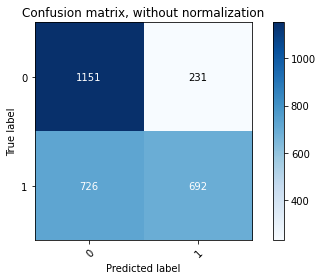

In [ ]:
testcorpus['samesession'] = testcorpus['samesession'].apply(int)

plot_confusion_matrix(testcorpus['samesession'], testcorpus['predict_samesession'], classes=np.array(['0','1']), title='Confusion matrix, without normalization')

In [ ]:
testcorpus['predict_samesession'].value_counts()

0    1877
1     923
Name: predict_samesession, dtype: int64